In [ ]:
#train sample sorting(30,000개-10,000/10,000/10,000)
#test sample sorting(30,000개-10,000/10,000/10,000)
import numpy as np 
import pandas as pd
import matplotlib as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df1 = pd.read_csv('/kaggle/input/2022-06-22/id_taxid_aspect_seq_term.csv')

df_CCO = df1[df1['aspect'] =='CCO']
df_BPO = df1[df1['aspect'] =='BPO']
df_MFO = df1[df1['aspect'] =='MFO']

term_columns = ['term1', 'term2', 'term3', 'term4', 'term5', 'term6', 'term7', 'term8', 'term9', 'term10', 
                'term11', 'term12', 'term13', 'term14', 'term15', 'term16', 'term17', 'term18', 'term19', 
                'term20','term21', 'term22', 'term23', 'term24', 'term25', 'term26', 'term27', 'term28', 
                'term29', 'term30', 'term31', 'term32', 'term33', 'term34', 'term35', 'term36', 'term37', 
                'term38', 'term39', 'term40', 'term41', 'term42', 'term43', 'term44', 'term45', 'term46', 
                'term47', 'term48', 'term49']

df_CCO.reset_index(drop=True, inplace = True)
df_CCO.drop(columns = term_columns, inplace = True)
df_BPO.reset_index(drop=True, inplace = True)
df_BPO.drop(columns = term_columns, inplace = True)
df_MFO.reset_index(drop=True, inplace = True)
df_MFO.drop(columns = term_columns, inplace = True)

#train set
df_train_CCO = df_CCO[:10000]
df_train_BPO = df_BPO[:10000]
df_train_MFO = df_MFO[:10000]

#test set
df_test_CCO = df_CCO[10000:20000]
df_test_BPO = df_BPO[10000:20000]
df_test_MFO = df_MFO[10000:20000]

#데이터 프레임 합치기
df_train_aspect = pd.concat([df_train_CCO, df_train_BPO, df_train_MFO])
df_train_aspect = df_train_aspect.reset_index(drop=True)

df_test_aspect = pd.concat([df_test_CCO, df_test_BPO, df_test_MFO])
df_test_aspect = df_test_aspect.reset_index(drop=True)

!pip install torchmetrics
!pip install pytorch_lightning
!pip install transformers

MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 5
    batch_size = 128
    lr = 0.001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(config.device)

print("Load ProtBERT Model...")
# PROT BERT LOADING :
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(config.device)

def get_bert_embedding(
    sequence : str,
    len_seq_limit : int
):
    '''
    Function to collect last hidden state embedding vector from pre-trained ProtBERT Model

    INPUTS:
    - sequence (str) : protein sequence (ex : AAABBB) from fasta file
    - len_seq_limit (int) : maximum sequence lenght (i.e nb of letters) for truncation

    OUTPUTS:
    - output_hidden : last hidden state embedding vector for input sequence of length 1024
    '''
    sequence_w_spaces = ' '.join(list(sequence))
    encoded_input = tokenizer(
        sequence_w_spaces,
        truncation=True,
        max_length=len_seq_limit,
        padding='max_length',
        return_tensors='pt').to(config.device)
    output = model(**encoded_input)
    output_hidden = output['last_hidden_state'][:,0][0].detach().cpu().numpy()
    assert len(output_hidden)==1024
    return output_hidden

아래코드 2번 1024개만 진행됨

In [ ]:
from joblib import Parallel, delayed
import numpy as np

print("Loading train set ProtBERT Embeddings...")
print("Total Nb of Elements : ", len(df_train_aspect))
aspect_list = []
embed_vects_list = []

def some_function(a):
    ### COLLECTING FOR TRAIN SAMPLES :
    aspect_list.append(a)
    
# def some_function2(a):
#     embed_vects_list.append(get_bert_embedding(sequence = a, len_seq_limit = 1200))
    
print("Embedding function End")

df = df_train_aspect[['aspect', 'sequence']]  # 'aspect'와 'sequence' 열 선택

Parallel(n_jobs=1)(delayed(some_function)(a) for a in df.aspect)
np.save('/kaggle/working/train_ids.npy', np.array(aspect_list))
print("Embedding 1 End")
# Parallel(n_jobs=1)(delayed(some_function2)(b) for b in df.sequence)
# np.save('/kaggle/working/train_embeddings.npy', np.array(embed_vects_list))
# print("Embedding 2 End")

In [ ]:
from joblib import Parallel, delayed
import numpy as np

print("Loading train set ProtBERT Embeddings...")
print("Total Nb of Elements : ", len(df_test_aspect))
aspect_list = []
embed_vects_list = []

def some_function(a):
    ### COLLECTING FOR TEST SAMPLES :
    aspect_list.append(a)
    
def some_function2(a):
    embed_vects_list.append(get_bert_embedding(sequence = a, len_seq_limit = 1200))
    
print("Embedding function End")

df = df_test_aspect[['aspect', 'sequence']]  # 'aspect'와 'sequence' 열 선택

Parallel(n_jobs=1)(delayed(some_function)(a) for a in df.aspect)
np.save('/kaggle/working/test_ids.npy', np.array(aspect_list))
print("Embedding 1 End")
Parallel(n_jobs=1)(delayed(some_function2)(b) for b in df.sequence)
np.save('/kaggle/working/test_embeddings.npy', np.array(embed_vects_list))
print("Embedding 2 End")

# 아래 모델 실행전 돌릴 코드

In [2]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

# Create the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [3]:
!pip install Bio
!pip install seaborn
!pip install xgboost
!pip install plotly
!pip install progressbar
!pip install transformers

#import libraiares:
import tensorflow as tf
import pandas as pd
import numpy as np

# we will use bio python to read the sequences
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import KNNImputer, SimpleImputer
#import statsmodels.api as sm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
#from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import re
from scipy.stats import randint

import plotly.express as px
from transformers import BertModel, BertTokenizer
import torch

# Required for progressbar widget
import progressbar
import time
t0start = time.time() 
from tqdm import tqdm




[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
train_aspect_list = np.load('/kaggle/input/2022-06-22/train_aspect.npy')
train_vector_list = np.load('/kaggle/input/2022-06-22/train_embedding_vector.npy')

In [5]:
train_vector_list

array([[ 1.6022518e-01,  4.0185247e-02,  6.8392225e-02, ...,
        -8.9387171e-02, -1.7991180e-02,  3.1597719e-02],
       [ 8.0765128e-02,  1.7988980e-02,  4.8682149e-02, ...,
        -2.2297828e-02, -1.3418330e-02, -1.0275565e-02],
       [ 1.1917543e-01,  5.7263691e-02,  7.9359002e-02, ...,
        -8.3864294e-02,  1.1563470e-04,  4.2442276e-04],
       ...,
       [ 1.2818383e-01,  8.8792421e-02,  7.5635046e-02, ...,
        -8.9212283e-02, -1.9264566e-02, -2.8378986e-02],
       [-2.8106775e-02,  3.3305638e-02,  5.3846095e-02, ...,
        -8.8601727e-03,  2.7309849e-03,  2.6909435e-02],
       [ 6.1304606e-02,  1.0011150e-01,  5.5041634e-02, ...,
        -2.2039725e-02,  5.3891800e-02, -1.1316695e-02]], dtype=float32)

In [6]:
train_aspect_list

array(['CCO', 'CCO', 'CCO', ..., 'MFO', 'MFO', 'MFO'], dtype='<U3')

# 1회차

In [6]:
print('train_vector_list.shape =',train_vector_list.shape)
print('train_aspect_list.shape =',train_aspect_list.shape)
print('train_aspect_list의 종류 =',np.unique(train_aspect_list))

train_vector_list.shape = (30000, 1024)
train_aspect_list.shape = (30000,)
train_aspect_list의 종류 = ['BPO' 'CCO' 'MFO']


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=3000, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

NameError: name 'train_test_split' is not defined

In [ ]:
# 딕셔너리 생성: 인코딩된 레이블과 원래 레이블의 매핑
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# 인코딩된 레이블과 원래 레이블의 매핑 출력
for index, label in label_mapping.items():
    print(f"Encoded label: {index}, Original label: {label}")

In [ ]:
# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

In [ ]:
print(history.history.keys())

In [ ]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 2회차
변경점 : layer unit수 조절(1/4씩 감소)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=1500, activation='relu'),
    tf.keras.layers.Dense(units=375, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

In [ ]:
# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 3차 시도 
: 과적합 해소 unit수 늘리기

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=24000, activation='relu'),
    tf.keras.layers.Dense(units=12000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

In [ ]:
# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 4차

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='sigmoid'),
    tf.keras.layers.Dense(units=6000, activation='sigmoid'),
    tf.keras.layers.Dense(units=3000, activation='sigmoid'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

In [ ]:
# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 5차 시도

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='tanh'),
    tf.keras.layers.Dense(units=6000, activation='tanh'),
    tf.keras.layers.Dense(units=3000, activation='tanh'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 6차
ReLu를 LeakyReLu로 변경

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/30


2023-07-23 07:26:44.362046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 07:26:44.415386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


749/750 [============================>.] - ETA: 0s - loss: 1.9660 - accuracy: 0.3592

2023-07-23 07:27:14.679650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 07:27:14.800582: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 43s 39ms/step - loss: 1.9651 - accuracy: 0.3590 - val_loss: 1.2031 - val_accuracy: 0.3582
Epoch 2/30
749/750 [============================>.] - ETA: 0s - loss: 1.1062 - accuracy: 0.3758

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 28s 38ms/step - loss: 1.1061 - accuracy: 0.3758 - val_loss: 1.0750 - val_accuracy: 0.4040
Epoch 3/30
750/750 [==============================] - 21s 28ms/step - loss: 1.1129 - accuracy: 0.3755 - val_loss: 1.1083 - val_accuracy: 0.3720
Epoch 4/30
750/750 [==============================] - 21s 29ms/step - loss: 1.1573 - accuracy: 0.3587 - val_loss: 1.1310 - val_accuracy: 0.3927
Epoch 5/30
750/750 [==============================] - 21s 28ms/step - loss: 1.1581 - accuracy: 0.3607 - val_loss: 1.1407 - val_accuracy: 0.3820
Epoch 6/30
750/750 [==============================] - 22s 29ms/step - loss: 27.2833 - accuracy: 0.3582 - val_loss: 50.5907 - val_accuracy: 0.3348
Epoch 7/30
750/750 [==============================] - 21s 29ms/step - loss: 2.4221 - accuracy: 0.3530 - val_loss: 1.2932 - val_accuracy: 0.3865
Epoch 8/30
750/750 [==============================] - 21s 28ms/step - loss: 1.1357 - accuracy: 0.3708 - val_loss: 1.1922 - val_accuracy: 0.3828
E

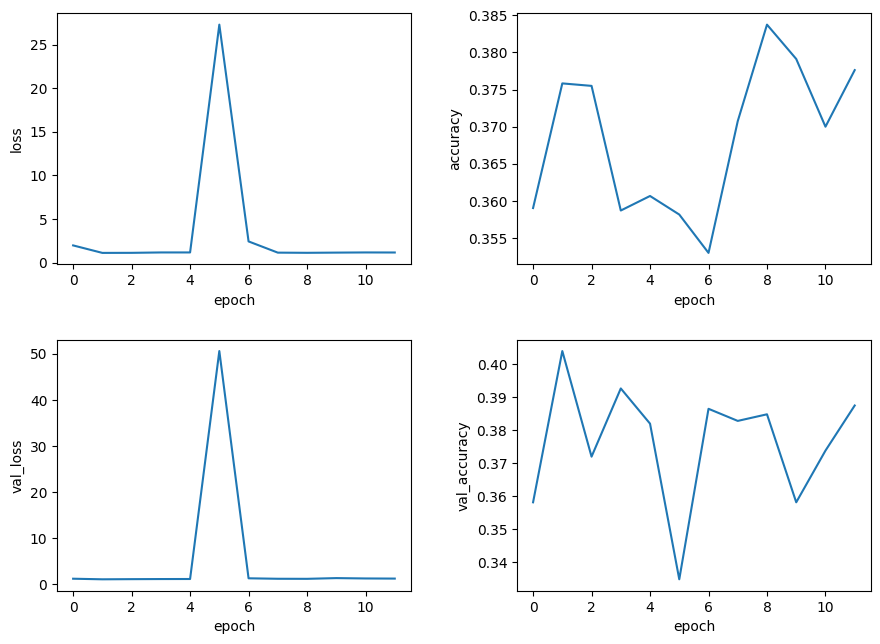

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LeakyReLU
# import create_model

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=6000, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=3000, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

# batch_size = 200
# steps_per_epoch = 60000 // batch_size
# validation_steps = 10000 // batch_size

# train_dataset = get_dataset(batch_size, is_training=True)
# test_dataset = get_dataset(batch_size, is_training=False)

# model.fit(train_dataset,
#           epochs=5,
#           steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset, 
#           validation_steps=validation_steps)
    
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

protbert training

# 7차
running rate 감소(1/10)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/30


2023-07-23 07:35:40.169124: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 07:35:40.216785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


749/750 [============================>.] - ETA: 0s - loss: 1.1356 - accuracy: 0.3667

2023-07-23 07:36:10.765414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 07:36:10.902953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 44s 40ms/step - loss: 1.1357 - accuracy: 0.3667 - val_loss: 1.1435 - val_accuracy: 0.3732
Epoch 2/30
749/750 [============================>.] - ETA: 0s - loss: 1.1034 - accuracy: 0.3811

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 28s 37ms/step - loss: 1.1035 - accuracy: 0.3810 - val_loss: 1.1401 - val_accuracy: 0.3858
Epoch 3/30
750/750 [==============================] - ETA: 0s - loss: 1.0936 - accuracy: 0.3929

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 28s 38ms/step - loss: 1.0936 - accuracy: 0.3929 - val_loss: 1.1245 - val_accuracy: 0.3822
Epoch 4/30
749/750 [============================>.] - ETA: 0s - loss: 1.0830 - accuracy: 0.4008

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 28s 37ms/step - loss: 1.0829 - accuracy: 0.4010 - val_loss: 1.0872 - val_accuracy: 0.4200
Epoch 5/30
750/750 [==============================] - 21s 28ms/step - loss: 1.0765 - accuracy: 0.4050 - val_loss: 1.0961 - val_accuracy: 0.4103
Epoch 6/30
749/750 [============================>.] - ETA: 0s - loss: 1.0709 - accuracy: 0.4116

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 28s 37ms/step - loss: 1.0708 - accuracy: 0.4117 - val_loss: 1.0807 - val_accuracy: 0.4233
Epoch 7/30
750/750 [==============================] - 21s 29ms/step - loss: 1.0625 - accuracy: 0.4148 - val_loss: 1.1228 - val_accuracy: 0.4143
Epoch 8/30
750/750 [==============================] - 21s 28ms/step - loss: 1.0585 - accuracy: 0.4257 - val_loss: 1.1035 - val_accuracy: 0.3843
Epoch 9/30
750/750 [==============================] - 21s 29ms/step - loss: 1.0503 - accuracy: 0.4295 - val_loss: 1.0908 - val_accuracy: 0.4248
Epoch 10/30
750/750 [==============================] - 22s 29ms/step - loss: 1.0480 - accuracy: 0.4339 - val_loss: 1.1063 - val_accuracy: 0.4117
Epoch 11/30
750/750 [==============================] - 21s 29ms/step - loss: 1.0412 - accuracy: 0.4339 - val_loss: 1.1100 - val_accuracy: 0.4167
Epoch 12/30
750/750 [==============================] - 21s 28ms/step - loss: 1.0407 - accuracy: 0.4359 - val_loss: 1.1405 - val_accuracy: 0.4217


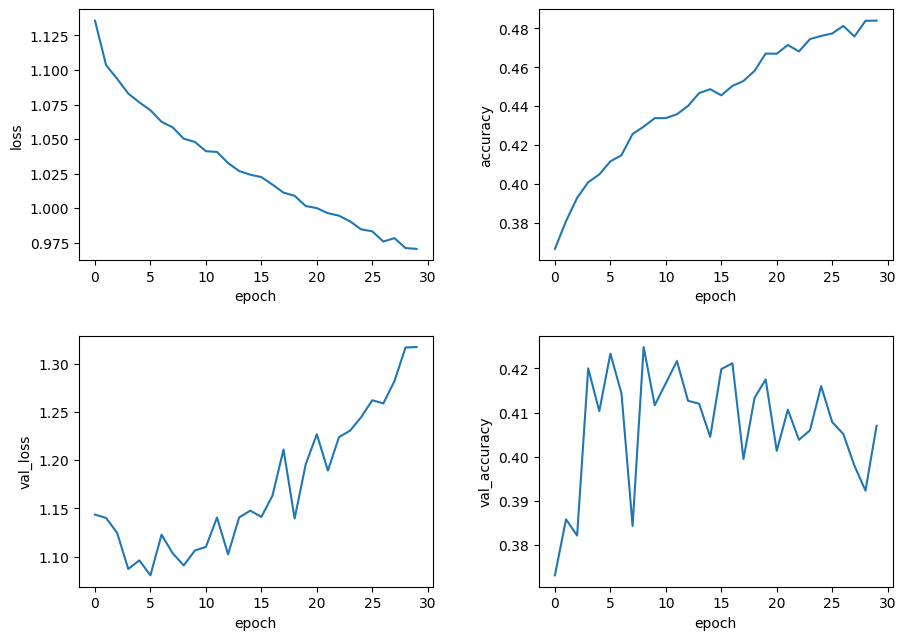

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LeakyReLU
# import create_model

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=6000, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=3000, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

# batch_size = 200
# steps_per_epoch = 60000 // batch_size
# validation_steps = 10000 // batch_size

# train_dataset = get_dataset(batch_size, is_training=True)
# test_dataset = get_dataset(batch_size, is_training=False)

# model.fit(train_dataset,
#           epochs=5,
#           steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset, 
#           validation_steps=validation_steps)
    
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 8차
신경망 깊이 늘리기

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/30


2023-07-23 07:48:04.235467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 07:48:04.280015: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


750/750 [==============================] - ETA: 0s - loss: 1.1015 - accuracy: 0.3767

2023-07-23 07:48:34.200122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 07:48:34.328690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 43s 40ms/step - loss: 1.1015 - accuracy: 0.3767 - val_loss: 1.0813 - val_accuracy: 0.3867
Epoch 2/30
750/750 [==============================] - ETA: 0s - loss: 1.0775 - accuracy: 0.4016

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 28s 38ms/step - loss: 1.0775 - accuracy: 0.4016 - val_loss: 1.0740 - val_accuracy: 0.4098
Epoch 3/30
750/750 [==============================] - 21s 28ms/step - loss: 1.0680 - accuracy: 0.4139 - val_loss: 1.0811 - val_accuracy: 0.4178
Epoch 4/30
750/750 [==============================] - 22s 29ms/step - loss: 1.0613 - accuracy: 0.4210 - val_loss: 1.0817 - val_accuracy: 0.4112
Epoch 5/30
750/750 [==============================] - 22s 29ms/step - loss: 1.0557 - accuracy: 0.4272 - val_loss: 1.1002 - val_accuracy: 0.4102
Epoch 6/30
750/750 [==============================] - 22s 29ms/step - loss: 1.0501 - accuracy: 0.4333 - val_loss: 1.1084 - val_accuracy: 0.4128
Epoch 7/30
750/750 [==============================] - 21s 29ms/step - loss: 1.0427 - accuracy: 0.4386 - val_loss: 1.1134 - val_accuracy: 0.4178
Epoch 8/30
750/750 [==============================] - 21s 29ms/step - loss: 1.0345 - accuracy: 0.4472 - val_loss: 1.1151 - val_accuracy: 0.4183
Epo

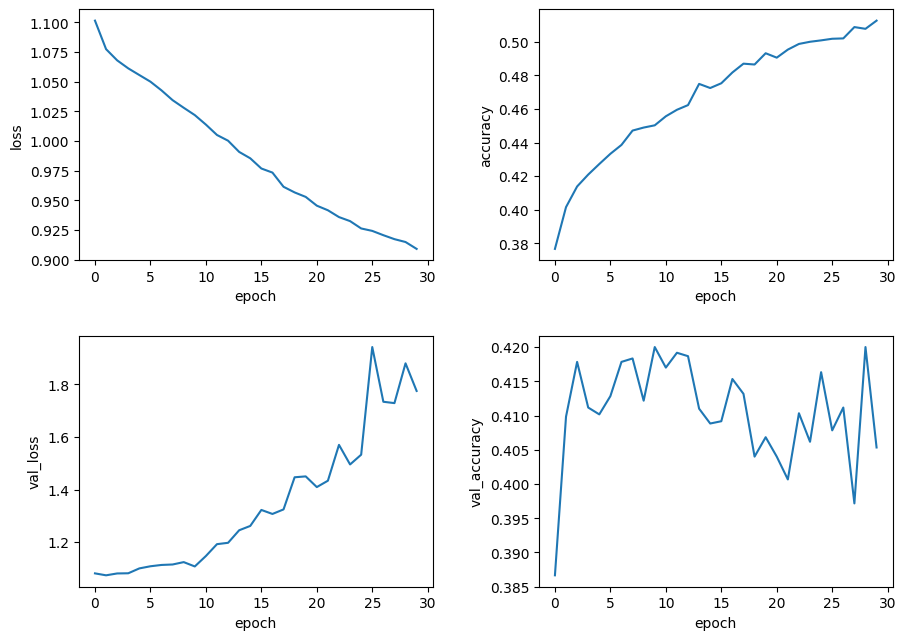

In [12]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LeakyReLU
# import create_model

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=3000, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

# batch_size = 200
# steps_per_epoch = 60000 // batch_size
# validation_steps = 10000 // batch_size

# train_dataset = get_dataset(batch_size, is_training=True)
# test_dataset = get_dataset(batch_size, is_training=False)

# model.fit(train_dataset,
#           epochs=5,
#           steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset, 
#           validation_steps=validation_steps)
    
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 8차
망 깊이 늘리기

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/30


2023-07-23 08:05:51.155426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 08:05:51.215608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


749/750 [============================>.] - ETA: 0s - loss: 1.0925 - accuracy: 0.3801

2023-07-23 08:06:23.035035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 08:06:23.166594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 47s 43ms/step - loss: 1.0925 - accuracy: 0.3800 - val_loss: 1.0841 - val_accuracy: 0.3965
Epoch 2/30
750/750 [==============================] - 23s 30ms/step - loss: 1.0792 - accuracy: 0.3973 - val_loss: 1.0990 - val_accuracy: 0.3962
Epoch 3/30
750/750 [==============================] - 22s 30ms/step - loss: 1.0727 - accuracy: 0.4100 - val_loss: 1.0864 - val_accuracy: 0.4053
Epoch 4/30
750/750 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.4162

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 30s 40ms/step - loss: 1.0669 - accuracy: 0.4162 - val_loss: 1.0760 - val_accuracy: 0.4057
Epoch 5/30
750/750 [==============================] - ETA: 0s - loss: 1.0633 - accuracy: 0.4162

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 30s 40ms/step - loss: 1.0633 - accuracy: 0.4162 - val_loss: 1.0756 - val_accuracy: 0.4173
Epoch 6/30
750/750 [==============================] - 22s 30ms/step - loss: 1.0570 - accuracy: 0.4286 - val_loss: 1.0802 - val_accuracy: 0.4193
Epoch 7/30
750/750 [==============================] - 22s 30ms/step - loss: 1.0512 - accuracy: 0.4291 - val_loss: 1.0991 - val_accuracy: 0.3995
Epoch 8/30
750/750 [==============================] - 23s 30ms/step - loss: 1.0463 - accuracy: 0.4340 - val_loss: 1.1200 - val_accuracy: 0.4243
Epoch 9/30
750/750 [==============================] - 22s 30ms/step - loss: 1.0407 - accuracy: 0.4425 - val_loss: 1.0990 - val_accuracy: 0.4245
Epoch 10/30
750/750 [==============================] - 22s 30ms/step - loss: 1.0327 - accuracy: 0.4462 - val_loss: 1.1218 - val_accuracy: 0.4122
Epoch 11/30
750/750 [==============================] - 23s 30ms/step - loss: 1.0261 - accuracy: 0.4505 - val_loss: 1.1575 - val_accuracy: 0.4118
E

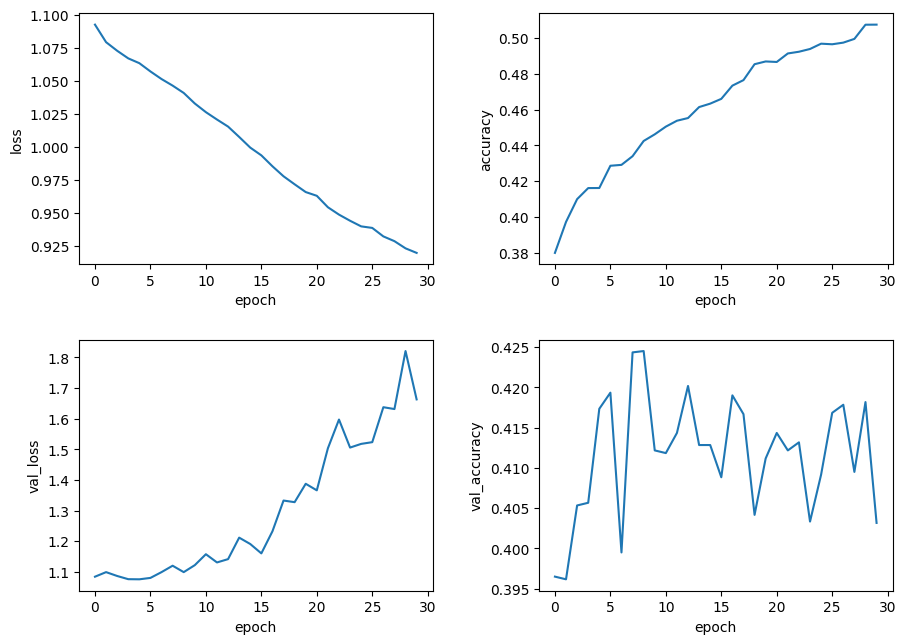

In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LeakyReLU
# import create_model

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=3000, activation='relu'),
    tf.keras.layers.Dense(units=1500, activation='relu'),
    tf.keras.layers.Dense(units=750, activation='relu'),
    tf.keras.layers.Dense(units=375, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

# batch_size = 200
# steps_per_epoch = 60000 // batch_size
# validation_steps = 10000 // batch_size

# train_dataset = get_dataset(batch_size, is_training=True)
# test_dataset = get_dataset(batch_size, is_training=False)

# model.fit(train_dataset,
#           epochs=5,
#           steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset, 
#           validation_steps=validation_steps)
    
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 9차
망 깊이 줄기

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/30


2023-07-23 08:17:50.622275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 08:17:50.665238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


748/750 [============================>.] - ETA: 0s - loss: 1.1056 - accuracy: 0.3856

2023-07-23 08:18:13.669347: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 08:18:13.804085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 34s 35ms/step - loss: 1.1056 - accuracy: 0.3856 - val_loss: 1.0930 - val_accuracy: 0.4072
Epoch 2/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0792 - accuracy: 0.3991 - val_loss: 1.1015 - val_accuracy: 0.4123
Epoch 3/30
750/750 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.4155

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 24s 32ms/step - loss: 1.0678 - accuracy: 0.4155 - val_loss: 1.0848 - val_accuracy: 0.4072
Epoch 4/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0609 - accuracy: 0.4205 - val_loss: 1.0975 - val_accuracy: 0.4023
Epoch 5/30
750/750 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.4242

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 24s 32ms/step - loss: 1.0547 - accuracy: 0.4242 - val_loss: 1.0795 - val_accuracy: 0.4223
Epoch 6/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0478 - accuracy: 0.4284 - val_loss: 1.0983 - val_accuracy: 0.4140
Epoch 7/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0400 - accuracy: 0.4403 - val_loss: 1.1243 - val_accuracy: 0.4103
Epoch 8/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0312 - accuracy: 0.4470 - val_loss: 1.1627 - val_accuracy: 0.4025
Epoch 9/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0236 - accuracy: 0.4463 - val_loss: 1.1491 - val_accuracy: 0.4152
Epoch 10/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0134 - accuracy: 0.4572 - val_loss: 1.1548 - val_accuracy: 0.4203
Epoch 11/30
750/750 [==============================] - 19s 25ms/step - loss: 1.0040 - accuracy: 0.4649 - val_loss: 1.1666 - val_accuracy: 0.4183
E

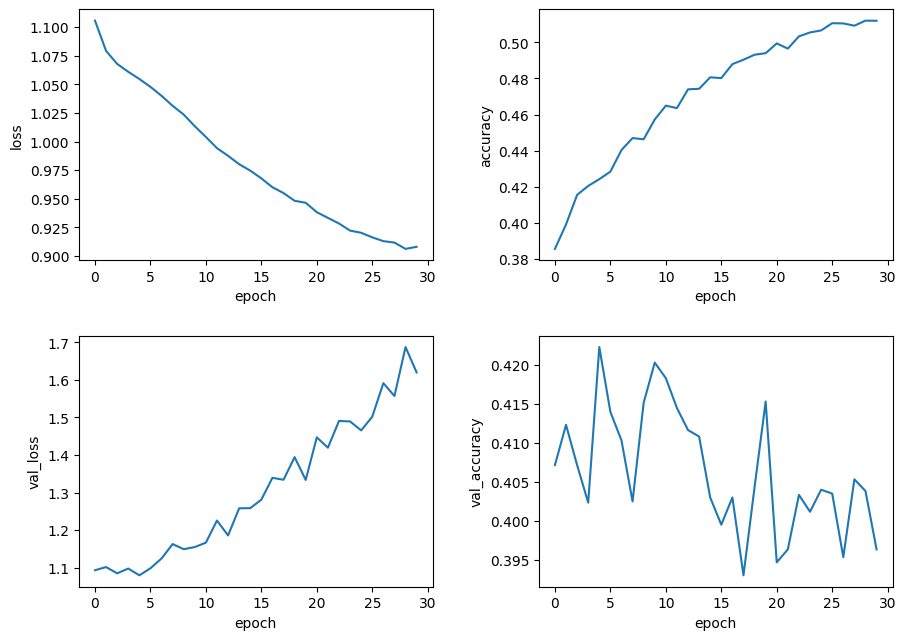

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LeakyReLU
# import create_model

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

# batch_size = 200
# steps_per_epoch = 60000 // batch_size
# validation_steps = 10000 // batch_size

# train_dataset = get_dataset(batch_size, is_training=True)
# test_dataset = get_dataset(batch_size, is_training=False)

# model.fit(train_dataset,
#           epochs=5,
#           steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset, 
#           validation_steps=validation_steps)
    
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

# 10차
L1정규화 사용

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import LeakyReLU
# import create_model

label_encoder = LabelEncoder()

X = train_vector_list
y = train_aspect_list
y = label_encoder.fit_transform(train_aspect_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify= train_aspect_list, random_state=42)

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120

num_of_labels = 3

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=12000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=6000, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels, activation='softmax')
])

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

# batch_size = 200
# steps_per_epoch = 60000 // batch_size
# validation_steps = 10000 // batch_size

# train_dataset = get_dataset(batch_size, is_training=True)
# test_dataset = get_dataset(batch_size, is_training=False)

# model.fit(train_dataset,
#           epochs=5,
#           steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset, 
#           validation_steps=validation_steps)
    
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.pro5", save_best_only=True)

# train new model
history = model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2)

# 격자 크기 설정
f.set_size_inches((10.5, 7.5))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')

plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Epoch 1/30


2023-07-23 08:46:55.364517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 08:46:55.417678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


749/750 [============================>.] - ETA: 0s - loss: 62.0307 - accuracy: 0.3315

2023-07-23 08:47:24.726450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-23 08:47:24.874426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 42s 45ms/step - loss: 61.9500 - accuracy: 0.3316 - val_loss: 1.2349 - val_accuracy: 0.3340
Epoch 2/30
749/750 [============================>.] - ETA: 0s - loss: 1.1100 - accuracy: 0.3318

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 31s 41ms/step - loss: 1.1100 - accuracy: 0.3318 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 3/30
750/750 [==============================] - 24s 32ms/step - loss: 1.3346 - accuracy: 0.3320 - val_loss: 1.1023 - val_accuracy: 0.3333
Epoch 4/30
750/750 [==============================] - 24s 32ms/step - loss: 1.2176 - accuracy: 0.3371 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 5/30
750/750 [==============================] - 24s 32ms/step - loss: 1.0993 - accuracy: 0.3323 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 6/30
750/750 [==============================] - 24s 32ms/step - loss: 1.0992 - accuracy: 0.3320 - val_loss: 1.0998 - val_accuracy: 0.3333
Epoch 7/30
750/750 [==============================] - 24s 32ms/step - loss: 1.0994 - accuracy: 0.3273 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 8/30
750/750 [==============================] - 24s 32ms/step - loss: 1.0994 - accuracy: 0.3302 - val_loss: 1.0989 - val_accuracy: 0.3333
Epo

INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


INFO:tensorflow:Assets written to: /kaggle/working/best_model.pro5/assets


750/750 [==============================] - 31s 41ms/step - loss: 1.0993 - accuracy: 0.3327 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 11/30
750/750 [==============================] - 24s 32ms/step - loss: 1.1514 - accuracy: 0.3282 - val_loss: 1.1010 - val_accuracy: 0.3333
Epoch 12/30
750/750 [==============================] - 24s 32ms/step - loss: 7.1482 - accuracy: 0.3369 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 13/30
339/750 [============>.................] - ETA: 11s - loss: 1.0991 - accuracy: 0.3342

KeyboardInterrupt: 

In [ ]:
! pip install -U git+https://github.com/huggingface/transformers.git
! pip install -U git+https://github.com/huggingface/accelerate.git

In [ ]:
!pip -q install transformers seqeval  

In [ ]:
import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import os
import pandas as pd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re

In [ ]:
model_name = 'Rostlab/prot_bert'

In [ ]:
class DeepLocDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, split="train", tokenizer_name='Rostlab/prot_bert_bfd', max_length=1024):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.datasetFolderPath = 'dataset/'
        self.trainFilePath = os.path.join(self.datasetFolderPath, 'deeploc_per_protein_train.csv')
        self.testFilePath = os.path.join(self.datasetFolderPath, 'deeploc_per_protein_test.csv')

        self.downloadDeeplocDataset()

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False)

        if split=="train":
          self.seqs, self.labels = self.load_dataset(self.trainFilePath)
        else:
          self.seqs, self.labels = self.load_dataset(self.testFilePath)

        self.max_length = max_length

    def downloadDeeplocDataset(self):
        # This downloads train and validation splits:
        deeplocDatasetTrainUrl = 'https://rostlab.org/~deepppi/deeploc_data/deeploc_our_train_set.csv'
        deeplocDatasetValidUrl = 'https://rostlab.org/~deepppi/deeploc_data/deeploc_our_val_set.csv'
        # To evaluate on final test set and setHARD from light-attention paper (https://github.com/HannesStark/protein-localization), use the following sets:
        # official deeploc test set: 'https://rostlab.org/~deepppi/deeploc_data/deeploc_test_set.csv'
        # new setHARD from light attention: 'https://rostlab.org/~deepppi/deeploc_data/setHARD.csv'
        if not os.path.exists(self.datasetFolderPath):
            os.makedirs(self.datasetFolderPath)

        def download_file(url, filename):
            response = requests.get(url, stream=True)
            with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                              total=int(response.headers.get('content-length', 0)),
                              desc=filename) as fout:
                for chunk in response.iter_content(chunk_size=4096):
                    fout.write(chunk)

        if not os.path.exists(self.trainFilePath):
            download_file(deeplocDatasetTrainUrl, self.trainFilePath)

        if not os.path.exists(self.testFilePath):
            download_file(deeplocDatasetValidUrl, self.testFilePath)

    def load_dataset(self,path):
        df = pd.read_csv(path,names=['input','loc','membrane'],skiprows=1)
        df = df.loc[df['membrane'].isin(["M","S"])]
        self.labels_dic = {0:'Soluble',
                           1:'Membrane'}

        df['labels'] = np.where(df['membrane']=='M', 1, 0)
        
        seq = list(df['input'])
        label = list(df['labels'])

        assert len(seq) == len(label)
        return seq, label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq = " ".join("".join(self.seqs[idx].split()))
        seq = re.sub(r"[UZOB]", "X", seq)

        seq_ids = self.tokenizer(seq, truncation=True, padding='max_length', max_length=self.max_length)

        sample = {key: torch.tensor(val) for key, val in seq_ids.items()}
        sample['labels'] = torch.tensor(self.labels[idx])

        return sample

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=1000,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,               # How often to print logs
    do_train=True,                   # Perform training
    do_eval=True,                    # Perform evaluation
    evaluation_strategy="epoch",     # evalute after eachh epoch
    gradient_accumulation_steps=64,  # total number of steps before back propagation
    fp16=True,                       # Use mixed precision
    fp16_opt_level="02",             # mixed precision mode
    run_name="ProBert-BFD-MS",       # experiment name
    seed=3                           # Seed for experiment reproducibility 3x3
)

trainer = Trainer(
    model_init=model_init,                # the instantiated 🤗 Transformers model to be trained
    args=training_args,                   # training arguments, defined above
    train_dataset=train_aspect_list,          # training dataset
    eval_dataset=train_vector_list,             # evaluation dataset
    compute_metrics = compute_metrics,    # evaluation metrics
)

trainer.train()

colab protbert

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [ ]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "2022-06-22"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024
}

In [ ]:
labels = {'BPO' : 0, 'CCO' : 1, 'MFO' : 2}

In [ ]:
import pandas as pd
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        #embeddings_source:
        embeds = np.load("/kaggle/input/2022-06-22/train_embedding_vector.npy")
        aspect = np.load("/kaggle/input/2022-06-22/train_aspect.npy")
            
        embeds_list = []
        aspect_list = []
        
        for l in embeds:
            embeds_list.append(l)
            
        for i in aspect:
            aspect_list.append(labels[i])
        
        self.df = pd.DataFrame(data={"Aspect": aspect_list, "embed" : embeds_list})
        
#         if datatype=="train":
#             df_labels = pd.read_pickle(
#                 "/kaggle/input/train-targets-top"+str(config.num_labels)+ \
#                 "/train_targets_top"+str(config.num_labels)+".pkl")
#             self.df = self.df.merge(df_labels, on="EntryID")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["Aspect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [ ]:
embeddings_source="T5"
model_type="linear"
train_size=0.9

train_dataset = ProteinSequenceDataset(datatype="train")
train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])

In [ ]:
embeddings_source="T5"
model_type="linear"

In [ ]:
train_dataset = ProteinSequenceDataset(datatype="train")
    
train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

if model_type == "linear":
    model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
if model_type == "convolutional":
    model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
CrossEntropy = torch.nn.CrossEntropyLoss()
f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
n_epochs = config.n_epochs

print("BEGIN TRAINING...")
#     train_loss_history=[]
#     val_loss_history=[]
    
train_f1score_history=[]
val_f1score_history=[]

In [ ]:
train_dataloader

In [ ]:
for epoch in range(n_epochs):
    print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
#         losses = []
    scores = []
    for embed, targets in tqdm(train_dataloader):
        embed, targets = embed.to(config.device), targets.to(config.device)
        optimizer.zero_grad()
        preds = model(embed)
#       loss= CrossEntropy(preds, targets)
        score=f1_score(preds, targets)
#       losses.append(loss.item()) 
        scores.append(score.item())
#             loss.backward()
        optimizer.step()
#         avg_loss = np.mean(losses)
    avg_score = np.mean(scores)
#         print("Running Average TRAIN Loss : ", avg_loss)
    print("Running Average TRAIN F1-Score : ", avg_score)
#         train_loss_history.append(avg_loss)
    train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
#         losses = []
    scores = []
    for embed, targets in val_dataloader:
        embed, targets = embed.to(config.device), targets.to(config.device)
        preds = model(embed)
#             loss= CrossEntropy(preds, targets)
        score=f1_score(preds, targets)
#             losses.append(loss.item())
        scores.append(score.item())
#         avg_loss = np.mean(losses)
    avg_score = np.mean(scores)
    print("Running Average VAL Loss : ", avg_loss)
    print("Running Average VAL F1-Score : ", avg_score)
#         val_loss_history.append(avg_loss)
    val_f1score_history.append(avg_score)
        
#         scheduler.step(avg_loss)
    print("\n")
        
print("TRAINING FINISHED")
print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
#     losses_history = {"train" : train_loss_history, "val" : val_loss_history}
scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

In [ ]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):
    
    train_dataset = ProteinSequenceDataset(datatype="train")
    
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
#     train_loss_history=[]
#     val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
#         losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
#             loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
#             losses.append(loss.item()) 
            scores.append(score.item())
#             loss.backward()
            optimizer.step()
#         avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
#         print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
#         train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
#         losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
#             loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
#             losses.append(loss.item())
            scores.append(score.item())
#         avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
#         val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
#         scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
#     losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
#     return model, losses_history, scores_history
    return model,scores_history

In [ ]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")